In [1]:
# -*- coding: utf-8 -*-

import scipy.io
import numpy as np
import tensorflow as tf
import sklearn as sk
import matplotlib.pyplot as plt
import itertools
import random

from numba import cuda
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import  EarlyStopping

In [2]:
# tensorflow = 2.
# python = 3.6


seed = np.random.seed(777)

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    
  try:
      
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      
  except RuntimeError as e:
      
    print(e)


val_loss_all = []

test_loss_all = []
test_acc_all = []
test_pre_all = []
frr_all = []
far_all = []

conf_matrix_sco = []
test_pre_sco = []
test_rec_sco = []
test_spedi_sco = []
test_sensi_sco = []

class MyModelCheckpoint(tf.keras.callbacks.ModelCheckpoint):

    def __init__(self, *args, **kwargs):
        super(MyModelCheckpoint, self).__init__(*args, **kwargs)

    # redefine the save so it only activates after 100 epochs
    def on_epoch_end(self, epoch, logs=None):
        if epoch >= 1: super(MyModelCheckpoint, self).on_epoch_end(epoch, logs)

In [3]:
train_data = scipy.io.loadmat('../../datas/160hz/train_5day_160hz.mat', squeeze_me=True)['data']
test_data = scipy.io.loadmat('../../datas/160hz/test_6day_160hz(2).mat', squeeze_me=True)['data']

# sub 수
sub_cnt = train_data.shape[0]

# 3sec 데이터 크기
data_size = 480

# 1명당 3초 데이터 개수
train_data_cnt = 1052
test_data_cnt = 211

# 3sec 480(= 160*3) 크기로 데이터 길이 설정
train_cut_size = 504960 # 480*1052 = 504960
test_cut_size = 101280 # 480*211 = 101280

# 3sec 데이터 길이 자르기
# train: 504,960 / test: 101,280
train_data = train_data[:,0:train_cut_size,:]
test_data = test_data[:,0:test_cut_size,:]

# flatten(): 3D -> 1D / reshape(-1,1): -1 마지막 인덱스
train_flatten = train_data.flatten().reshape(-1,1)
test_flatten = test_data.flatten().reshape(-1,1)

# StandardScaler(): train에 맞춰 표준화
data_scaler = StandardScaler()
    
data_scaler.fit(train_flatten)
train_scaler = data_scaler.transform(train_flatten)
test_scaler = data_scaler.transform(test_flatten)
    
# train, test 데이터 reshape
train_data = train_scaler.reshape(train_data_cnt * sub_cnt, data_size, 2) 
test_data = test_scaler.reshape(test_data_cnt * sub_cnt, data_size, 2)

#train data를 sub:other=1:1로 만들기 위해서 각 sub 추출
train_data_each = []
for i in range(sub_cnt):
    train_data_each.insert(i, train_data[i*train_data_cnt:(i+1)*train_data_cnt, :, :])
print(np.shape(train_data_each))

#test data를 sub:other=1:3로 만들기 위해서 각 sub 추출
test_data_each = []
for i in range(sub_cnt):
    test_data_each.insert(i, test_data[i*test_data_cnt:(i+1)*test_data_cnt, :, :])
print(np.shape(test_data_each))

(11, 1052, 480, 2)
(11, 211, 480, 2)


In [4]:
# sub number
sub_num = 7

#1 to 3 비율로 설정
ratio = 3

train_data_n = train_data_each[sub_num]
test_data_n = test_data_each[sub_num]

# train data를 sub:other = 1:3으로 만들기
# 3초 덩어리 개수 1052 : 3156
# => 315 * 4 + 316 * 6 = 1260 + 1896 = 3156

# test data를 sub:other = 1:3로 만들기
# 3초 덩어리 개수 211 : 633
# 63 * 7 + 64 * 3 = 633

cnt = 0
for j in range(sub_cnt):
    if j != sub_num and cnt < 4:
        cnt = cnt + 1
        train_data_n = np.append(train_data_n, np.array(random.sample(list(train_data_each[j]), 315)), axis = 0)
    elif j != sub_num and cnt >= 4:
        train_data_n = np.append(train_data_n, np.array(random.sample(list(train_data_each[j]), 316)), axis = 0)
#     print("train_data_n.shape")
#     print(train_data_n.shape)
#     print("train_data_n")
#     print(train_data_n)
        
cnt = 0
for j in range(sub_cnt):
    if j != sub_num and cnt < 7:
        cnt = cnt + 1
        test_data_n = np.append(test_data_n, np.array(random.sample(list(test_data_each[j]), 63)), axis = 0)
    elif j != sub_num and cnt >= 7:
        test_data_n = np.append(test_data_n, np.array(random.sample(list(test_data_each[j]), 64)), axis = 0)
        
        
        
train_label = np.zeros(train_data_cnt*(ratio+1))
test_label = np.zeros(test_data_cnt*(ratio+1))

for j in range(len(train_label)):
    if (j < train_data_cnt):
        train_label[j] = 1

for j in range(len(test_label)):
    if (j < test_data_cnt):
        test_label[j] = 1
        
train_data_shuffled, train_label_shuffled = sk.utils.shuffle(train_data_n, train_label, random_state = 0)

val_data_set = train_data_shuffled[:train_data_cnt]
train_data_set = train_data_shuffled[train_data_cnt:]

val_label_set = train_label_shuffled[:train_data_cnt]
train_label_set = train_label_shuffled[train_data_cnt:]
  

Epoch 1/200
99/99 [==============================] - 5s 51ms/step - loss: 0.5055 - accuracy: 0.7487 - val_loss: 0.4615 - val_accuracy: 0.7367
Epoch 2/200
99/99 [==============================] - ETA: 0s - loss: 0.4066 - accuracy: 0.7944
Epoch 00002: val_loss improved from inf to 0.40295, saving model to best_model_8.h5
99/99 [==============================] - 5s 48ms/step - loss: 0.4066 - accuracy: 0.7944 - val_loss: 0.4029 - val_accuracy: 0.8042
Epoch 3/200
98/99 [============================>.] - ETA: 0s - loss: 0.3870 - accuracy: 0.8163
Epoch 00003: val_loss did not improve from 0.40295
99/99 [==============================] - 5s 50ms/step - loss: 0.3858 - accuracy: 0.8175 - val_loss: 0.4125 - val_accuracy: 0.8298
Epoch 4/200
98/99 [============================>.] - ETA: 0s - loss: 0.3488 - accuracy: 0.8549
Epoch 00004: val_loss improved from 0.40295 to 0.37046, saving model to best_model_8.h5
99/99 [==============================] - 5s 51ms/step - loss: 0.3497 - accuracy: 0.8542 - 

Epoch 30/200
98/99 [============================>.] - ETA: 0s - loss: 0.1309 - accuracy: 0.9455
Epoch 00030: val_loss did not improve from 0.18563
99/99 [==============================] - 6s 58ms/step - loss: 0.1306 - accuracy: 0.9455 - val_loss: 0.1991 - val_accuracy: 0.9221
Epoch 31/200
99/99 [==============================] - ETA: 0s - loss: 0.1435 - accuracy: 0.9420
Epoch 00031: val_loss did not improve from 0.18563
99/99 [==============================] - 6s 58ms/step - loss: 0.1435 - accuracy: 0.9420 - val_loss: 0.2757 - val_accuracy: 0.8983
Epoch 32/200
99/99 [==============================] - ETA: 0s - loss: 0.1419 - accuracy: 0.9449
Epoch 00032: val_loss did not improve from 0.18563
99/99 [==============================] - 6s 59ms/step - loss: 0.1419 - accuracy: 0.9449 - val_loss: 0.2001 - val_accuracy: 0.9135
Epoch 33/200
98/99 [============================>.] - ETA: 0s - loss: 0.1375 - accuracy: 0.9467
Epoch 00033: val_loss did not improve from 0.18563
99/99 [===============

Epoch 60/200
99/99 [==============================] - ETA: 0s - loss: 0.0702 - accuracy: 0.9740
Epoch 00060: val_loss did not improve from 0.18398
99/99 [==============================] - 6s 58ms/step - loss: 0.0702 - accuracy: 0.9740 - val_loss: 0.2908 - val_accuracy: 0.9021
Epoch 61/200
98/99 [============================>.] - ETA: 0s - loss: 0.0601 - accuracy: 0.9780
Epoch 00061: val_loss did not improve from 0.18398
99/99 [==============================] - 6s 56ms/step - loss: 0.0601 - accuracy: 0.9781 - val_loss: 0.2590 - val_accuracy: 0.9021
Epoch 62/200
99/99 [==============================] - ETA: 0s - loss: 0.0688 - accuracy: 0.9747
Epoch 00062: val_loss did not improve from 0.18398
99/99 [==============================] - 6s 58ms/step - loss: 0.0688 - accuracy: 0.9747 - val_loss: 0.2439 - val_accuracy: 0.9202
Epoch 63/200
98/99 [============================>.] - ETA: 0s - loss: 0.0469 - accuracy: 0.9802
Epoch 00063: val_loss did not improve from 0.18398
99/99 [===============

Epoch 90/200
98/99 [============================>.] - ETA: 0s - loss: 0.0200 - accuracy: 0.9917
Epoch 00090: val_loss did not improve from 0.18398
99/99 [==============================] - 6s 56ms/step - loss: 0.0206 - accuracy: 0.9914 - val_loss: 0.4075 - val_accuracy: 0.9297
Epoch 91/200
98/99 [============================>.] - ETA: 0s - loss: 0.0366 - accuracy: 0.9882
Epoch 00091: val_loss did not improve from 0.18398
99/99 [==============================] - 6s 57ms/step - loss: 0.0364 - accuracy: 0.9883 - val_loss: 0.3608 - val_accuracy: 0.9106
Epoch 92/200
99/99 [==============================] - ETA: 0s - loss: 0.0211 - accuracy: 0.9911
Epoch 00092: val_loss did not improve from 0.18398
99/99 [==============================] - 6s 59ms/step - loss: 0.0211 - accuracy: 0.9911 - val_loss: 0.3045 - val_accuracy: 0.9202
Epoch 93/200
98/99 [============================>.] - ETA: 0s - loss: 0.0210 - accuracy: 0.9927
Epoch 00093: val_loss did not improve from 0.18398
99/99 [===============

Epoch 120/200
99/99 [==============================] - ETA: 0s - loss: 0.0182 - accuracy: 0.9943
Epoch 00120: val_loss did not improve from 0.18398
99/99 [==============================] - 5s 54ms/step - loss: 0.0182 - accuracy: 0.9943 - val_loss: 0.4237 - val_accuracy: 0.9192
Epoch 121/200
98/99 [============================>.] - ETA: 0s - loss: 0.0195 - accuracy: 0.9923
Epoch 00121: val_loss did not improve from 0.18398
99/99 [==============================] - 5s 49ms/step - loss: 0.0194 - accuracy: 0.9924 - val_loss: 0.4053 - val_accuracy: 0.9221
Epoch 122/200
98/99 [============================>.] - ETA: 0s - loss: 0.0159 - accuracy: 0.9946
Epoch 00122: val_loss did not improve from 0.18398
99/99 [==============================] - 5s 49ms/step - loss: 0.0163 - accuracy: 0.9943 - val_loss: 0.4165 - val_accuracy: 0.8983
Epoch 123/200
98/99 [============================>.] - ETA: 0s - loss: 0.0138 - accuracy: 0.9949
Epoch 00123: val_loss did not improve from 0.18398
99/99 [===========

Epoch 150/200
98/99 [============================>.] - ETA: 0s - loss: 0.0089 - accuracy: 0.9968
Epoch 00150: val_loss did not improve from 0.18398
99/99 [==============================] - 4s 43ms/step - loss: 0.0089 - accuracy: 0.9968 - val_loss: 0.4426 - val_accuracy: 0.9192
Epoch 151/200
99/99 [==============================] - ETA: 0s - loss: 0.0146 - accuracy: 0.9956
Epoch 00151: val_loss did not improve from 0.18398
99/99 [==============================] - 4s 43ms/step - loss: 0.0146 - accuracy: 0.9956 - val_loss: 0.4001 - val_accuracy: 0.9154
Epoch 152/200
99/99 [==============================] - ETA: 0s - loss: 0.0179 - accuracy: 0.9924
Epoch 00152: val_loss did not improve from 0.18398
99/99 [==============================] - 4s 43ms/step - loss: 0.0179 - accuracy: 0.9924 - val_loss: 0.3645 - val_accuracy: 0.9135
Epoch 153/200
99/99 [==============================] - ETA: 0s - loss: 0.0194 - accuracy: 0.9930
Epoch 00153: val_loss did not improve from 0.18398
99/99 [===========

Epoch 180/200
99/99 [==============================] - ETA: 0s - loss: 0.0682 - accuracy: 0.9731
Epoch 00180: val_loss did not improve from 0.18398
99/99 [==============================] - 4s 35ms/step - loss: 0.0682 - accuracy: 0.9731 - val_loss: 0.3621 - val_accuracy: 0.9135
Epoch 181/200
99/99 [==============================] - ETA: 0s - loss: 0.0056 - accuracy: 0.9981
Epoch 00181: val_loss did not improve from 0.18398
99/99 [==============================] - 4s 36ms/step - loss: 0.0056 - accuracy: 0.9981 - val_loss: 0.4371 - val_accuracy: 0.9154
Epoch 182/200
99/99 [==============================] - ETA: 0s - loss: 0.0193 - accuracy: 0.9937
Epoch 00182: val_loss did not improve from 0.18398
99/99 [==============================] - 3s 35ms/step - loss: 0.0193 - accuracy: 0.9937 - val_loss: 0.4447 - val_accuracy: 0.9030
Epoch 183/200
99/99 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9952
Epoch 00183: val_loss did not improve from 0.18398
99/99 [===========

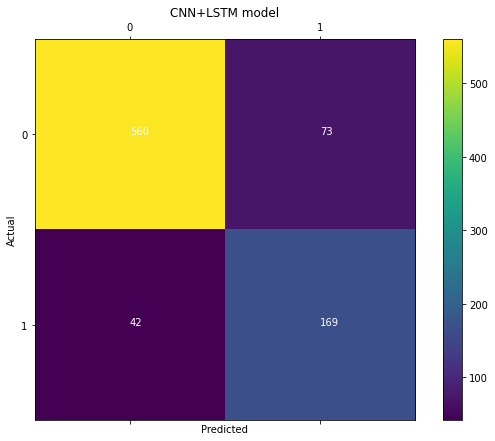

val_loss: 0.1839839369058609
test_loss: 0.3671511709690094
test_acc: 0.8637440800666809
precision: 0.6983471074380165
recall: 0.8009478672985783
specificity 0.8846761453396524
sensitivity :  0.8009478672985783
far 0.11532385466034756
frr 0.1990521327014218


In [5]:
# model CNN-LSTM    
inputs = tf.keras.Input(shape = (480, 2))
conv_1 = tf.keras.layers.Conv1D(filters = 180, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(inputs)
max_1 = tf.keras.layers.MaxPool1D(3)(conv_1)
    
conv_2 = tf.keras.layers.Conv1D(filters = 21, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(max_1)
max_2 = tf.keras.layers.MaxPool1D(3)(conv_2)
    
conv_3 = tf.keras.layers.Conv1D(filters = 193, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(max_2)
max_3 = tf.keras.layers.MaxPool1D(3)(conv_3)
    

D_out_1 = tf.keras.layers.Dropout(0.5904351267174524)(max_3)
    
    
lstm_1 = tf.keras.layers.LSTM(216)(D_out_1)
    
dense_1 = tf.keras.layers.Dense(36, activation = 'relu')(lstm_1)
dense_2 = tf.keras.layers.Dense(231, activation = 'relu')(dense_1)
dense_3 = tf.keras.layers.Dense(8, activation = 'relu')(dense_2)
dense_4 = tf.keras.layers.Dense(1, activation = 'sigmoid')(dense_3)
    
model = tf.keras.models.Model(inputs = inputs, outputs = dense_4)

# Adam
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(0.00048477250069401214), metrics = ['accuracy'])
# SGD
# model.compile(loss= 'binary_crossentropy', optimizer= tf.keras.optimizers.SGD(learning_rate=0.0461300729767683, momentum=0.4411297369087802), metrics=['accuracy'])
    
# EarlyStopping 조기종료 및 모델 학습
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 20)
check_point = MyModelCheckpoint('best_model_' + str(sub_num + 1) + '.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)

# EarlyStopping 사용
# hist = model.fit(train_data_set, train_label_set, epochs = 200, batch_size = 32, validation_data = (val_data_set, val_label_set), callbacks = [early_stopping, check_point])
# EarlyStopping 미사용
hist = model.fit(train_data_set, train_label_set, epochs = 200, batch_size = 32, validation_data = (val_data_set, val_label_set), callbacks = [check_point])
        
# model save .h5형식
model = tf.keras.models.load_model('best_model_' + str(sub_num + 1) + '.h5')
model.save('Binary_BOHB_' + str(sub_num + 1) + '.h5')
model.summary() 
        
val_loss, val_acc = model.evaluate(val_data_set, val_label_set, verbose = 2)

test_loss, test_acc = model.evaluate(test_data_n, test_label, verbose = 2)
test_pred = model.predict(test_data_n)
        
    
# 각 행은 1sec, 0.5 <= 자신, 0.5 > 타인
for i in range(len(test_pred)):
    if(test_pred[i] >= 0.5):
        test_pred[i] = 1
    
    else: 
        test_pred[i] = 0
    
    
val_loss_all.append(val_loss)
    
test_loss_all.append(test_loss)
test_acc_all.append(test_acc)
test_pre_all.append(test_pred)
    

conf_matrix = confusion_matrix(test_label, test_pred) 
conf_matrix_sco.append(conf_matrix)
    
conf_row = conf_matrix.sum(axis = 1)
conf_col = conf_matrix.sum(axis = 0)

precision = conf_matrix[1][1] / conf_col[1]
recall = conf_matrix[1][1] / conf_row[1]
specificity = conf_matrix[0][0] / conf_row[0]
sensitivity = conf_matrix[1][1] / conf_row[1]
frr = conf_matrix[1][0] / (conf_matrix[1][1]+conf_matrix[1][0])
far = conf_matrix[0][1] / (conf_matrix[0][1]+conf_matrix[0][0])
    
frr_all.append(frr)
far_all.append(far)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

cax = ax.matshow(conf_matrix)

fig.colorbar(cax)

for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j], color="white")

plt.title('CNN+LSTM model')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()
 
    
test_pre_sco.append(precision)
test_rec_sco.append(recall)
test_spedi_sco.append(specificity)
test_sensi_sco.append(sensitivity)
    
print('val_loss:', val_loss)
print('test_loss:', test_loss)
print('test_acc:', test_acc)
    
print('precision:', precision)
print('recall:', recall)
print('specificity', specificity)
print('sensitivity : ', sensitivity)
print('far', far)
print('frr', frr)